In [1]:
# SETUP
import matplotlib.pyplot as plt
from sklearn.metrics import PrecisionRecallDisplay
import numpy as np
import json
import requests
import pandas as pd

In [28]:
#QRELS_FILE = 'q4_rels.txt' # 5 --> 4
#QUERY_URL = 'http://localhost:8983/solr/trial_book/query?q=nightwing%20OR%20batman&q.op=OR&defType=edismax&indent=true&qf=title%20description&wt=json' #nightwing
#QUERY_URL_BOOST = 'http://localhost:8983/solr/trial_book/query?q=nightwing%20OR%20batman&q.op=OR&defType=edismax&indent=true&qf=title%20description&bq=title:batman*&wt=json'

QRELS_FILE = 'q6_qrels.txt' # 6
QUERY_URL = 'http://localhost:8983/solr/trial_book/query?q=%5B4%20TO%205%5D%20Thriller&q.op=OR&defType=edismax&indent=true&lowercaseOperators=false&rows=20&qf=rating%20genre&wt=json' #rating and thriller
QUERY_URL_BOOST = 'http://localhost:8983/solr/trial_book/query?q=%5B4%20TO%205%5D%20Thriller&q.op=OR&defType=edismax&indent=true&lowercaseOperators=false&rows=20&qf=rating%5E10%20genre%5E20&wt=json' #rating and thriller

#QRELS_FILE = 'q5_rels.txt' # 7 --> 5
#QUERY_URL = 'http://localhost:8983/solr/trial_book/query?q=written%20women~1&q.op=OR&defType=edismax&indent=true&qf=description%20review&wt=json' #written by or for women
#QUERY_URL_BOOST = 'http://localhost:8983/solr/trial_book/query?q=written%20women~1&q.op=OR&defType=edismax&indent=true&qf=description%5E10%20review&wt=json'


In [29]:
# Read qrels to extract relevant documents
relevant = list(map(lambda el: el.strip(), open(QRELS_FILE).readlines()))
# Get query results from Solr instance
normal_results = requests.get(QUERY_URL).json()['response']['docs']
boosted_results = requests.get(QUERY_URL_BOOST).json()['response']['docs']

FileNotFoundError: [Errno 2] No such file or directory: 'q6_qrels.txt'

In [26]:
# METRICS TABLE
# Define custom decorator to automatically calculate metric based on key
metrics = {}
metric = lambda f: metrics.setdefault(f.__name__, f)

@metric
def ap(results, relevant):
    """Average Precision"""
    precision_values = [
        len([
            doc 
            for doc in results[:idx]
            if doc['id'] in relevant
        ]) / idx 
        for idx in range(1, len(results))
    ]
    return sum(precision_values)/len(precision_values)

@metric
def p10(results, relevant, n=10):
    """Precision at N"""
    return len([doc for doc in results[:n] if doc['id'] in relevant])/n

def calculate_metric(key, results, relevant):
    return metrics[key](results, relevant)

# Define metrics to be calculated
evaluation_metrics = {
    'ap': 'Average Precision',
    'p10': 'Precision at 10 (P@10)'
}

# Calculate all metrics and export results as LaTeX table
df = pd.DataFrame([['Metric','Value']] +
    [
        [evaluation_metrics[m], calculate_metric(m, boosted_results, relevant)]
        for m in evaluation_metrics
    ]
)

with open('boosted_schema_q4_python.tex','w') as tf:
    tf.write(df.to_latex())


C:\Users\melis\AppData\Local\Temp\ipykernel_10884\4117469048.py:42: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  tf.write(df.to_latex())


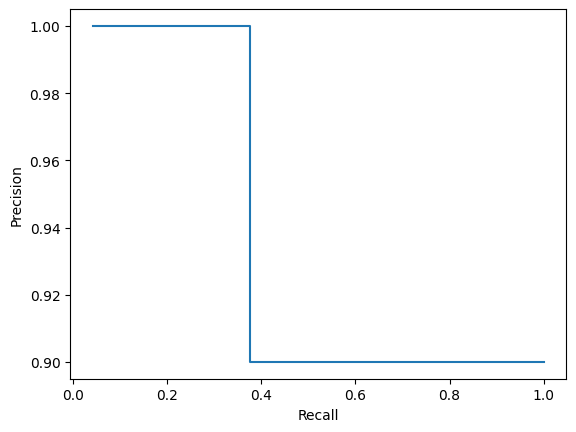

In [27]:
# PRECISION-RECALL CURVE
# Calculate precision and recall values as we move down the ranked list
precision_values = [
    len([
        doc 
        for doc in boosted_results[:idx]
        if doc['id'] in relevant
    ]) / idx 
    for idx, _ in enumerate(boosted_results, start=1)
]

recall_values = [
    len([
        doc for doc in boosted_results[:idx]
        if doc['id'] in relevant
    ]) / len(relevant)
    for idx, _ in enumerate(boosted_results, start=1)
]

precision_recall_match = {k: v for k,v in zip(recall_values, precision_values)}

# Extend recall_values to include traditional steps for a better curve (0.1, 0.2 ...)
recall_values.extend([step for step in np.arange(0.1, 1.1, 0.1) if step not in recall_values])
recall_values = sorted(set(recall_values))

# Extend matching dict to include these new intermediate steps
for idx, step in enumerate(recall_values):
    if step not in precision_recall_match:
        if recall_values[idx-1] in precision_recall_match:
            precision_recall_match[step] = precision_recall_match[recall_values[idx-1]]
        else:
            precision_recall_match[step] = precision_recall_match[recall_values[idx+1]]

disp = PrecisionRecallDisplay([precision_recall_match.get(r) for r in recall_values], recall_values)
disp.plot()
plt.savefig('precision_recall_boosted_schema_q4_python.png')